In [2]:
import pennylane as qml
import pennylane.numpy as np
import matplotlib.pyplot as plt

# Constants


In [3]:
noise_probability = 0.8

Q_qubits = 1
A_qubits = 2
B_qubits = 2

Q_wires = list(range(Q_qubits))
A_wires = list(range(Q_qubits, Q_qubits + A_qubits))
B_wires = list(range(Q_qubits + A_qubits, Q_qubits + A_qubits + B_qubits))

#Dimensions of the unitary matrix for QA
dim = 2 ** (Q_qubits + A_qubits)

alpha_length = 18
beta_length = 38

#Quantum Device
dev = qml.device('default.mixed', wires=Q_qubits + A_qubits + B_qubits)

# Gradient Descent parameters
stepsize = 0.01
momentum = 0.9

# Number of iterations
num_its = 300

# Number of simulations
num_sim = 80

# Baseline Fidelity
f_0 = 0.822

# Circuit definition
![VQACircuit](./Images/VQAcircuit.png)

![V W Definitions](./Images/V%20W%20Definitions.png)

# $\hat{V}_{QA}$

In [4]:
def prepare_Q(U, wires):
    """Prepares Q into the quantum state defined by the unitary U

    Args:
        U (array[complex]): the matrix U to apply to the fiduciary quantum state of Q
        wires (array[int]): the wires representing Q. If Q is a single-qubit, then this should be an array of length 1.
    """
    qml.QubitUnitary(U, wires)

In [5]:
def prepare_V_QA(alpha, wires):
    """Prepares the V_QA parametric gate given the vector alpha for a Q with k=1 qubits

    Args:
        alpha (array[complex]): The alpha vector containing the angles used for rotation in the Pauli operators
        wires (array[int]): The wires to act on. wires[0] should represent Q, and wires[1..2] shoudl represent A
    """
    # First two gates for each wire
    qml.RY(alpha[0], wires=wires[0])
    qml.RX(alpha[1], wires=wires[0])

    qml.RY(alpha[6], wires=wires[1])
    qml.RX(alpha[7], wires=wires[1])

    qml.RY(alpha[12], wires=wires[2])
    qml.RX(alpha[13], wires=wires[2])

    # Controlled on wire 0
    qml.CRX(alpha[8], wires=[wires[0], wires[1]])
    qml.CRX(alpha[14], wires=[wires[0], wires[2]])

    # Controlled on wire 1
    qml.CRX(alpha[2], wires=[wires[1], wires[0]])
    qml.CRX(alpha[15], wires=[wires[1], wires[2]])

    # Controlled on wire 2
    qml.CRX(alpha[3], wires=[wires[2], wires[0]])
    qml.CRX(alpha[9], wires=[wires[2], wires[1]])

    # Last two gates for each wire
    qml.RY(alpha[4], wires=wires[0])
    qml.RX(alpha[5], wires=wires[0])

    qml.RY(alpha[10], wires=wires[1])
    qml.RX(alpha[11], wires=wires[1])

    qml.RY(alpha[16], wires=wires[2])
    qml.RX(alpha[17], wires=wires[2])

# $\hat{W}_{QAB}$

In [6]:
def prepare_W_QAB(beta, wires):
    """Prepares the W_QAB parametric gate given the vector beta for a Q with k=1 qubits

    Args:
        beta (array[complex]): The beta vector containing the angles used for rotation in the Pauli operators
        wires (array[int]): The wires to act on. wires[0] should represent Q, wires[1..2] should represent A, and wires[3..4] should represent B
    """
    # First two gates for each wire
    qml.RY(beta[0], wires=wires[0])
    qml.RX(beta[1], wires=wires[0])

    qml.RY(beta[10], wires=wires[1])
    qml.RX(beta[11], wires=wires[1])

    qml.RY(beta[20], wires=wires[2])
    qml.RX(beta[21], wires=wires[2])

    qml.RY(beta[30], wires=wires[3])
    qml.RX(beta[31], wires=wires[3])

    qml.RY(beta[34], wires=wires[4])
    qml.RX(beta[35], wires=wires[4])

    # Controlled on wire 3
    qml.CRX(beta[2], wires=[wires[3], wires[0]])
    qml.CRZ(beta[3], wires=[wires[3], wires[0]])

    qml.CRX(beta[12], wires=[wires[3], wires[1]])
    qml.CRZ(beta[13], wires=[wires[3], wires[1]])

    qml.CRX(beta[22], wires=[wires[3], wires[2]])
    qml.CRZ(beta[23], wires=[wires[3], wires[2]])

    # Controlled on wire 4
    qml.CRX(beta[4], wires=[wires[4], wires[0]])
    qml.CRZ(beta[5], wires=[wires[4], wires[0]])

    qml.CRX(beta[14], wires=[wires[4], wires[1]])
    qml.CRZ(beta[15], wires=[wires[4], wires[1]])

    qml.CRX(beta[24], wires=[wires[4], wires[2]])
    qml.CRZ(beta[25], wires=[wires[4], wires[2]])

    # Middle rotation gates for each wire
    qml.RY(beta[6], wires=wires[0])
    qml.RX(beta[7], wires=wires[0])

    qml.RY(beta[16], wires=wires[1])
    qml.RX(beta[17], wires=wires[1])

    qml.RY(beta[26], wires=wires[2])
    qml.RX(beta[27], wires=wires[2])

    qml.RY(beta[22], wires=wires[3])
    qml.RX(beta[23], wires=wires[3])

    qml.RY(beta[36], wires=wires[4])
    qml.RX(beta[37], wires=wires[4])

    # Controlled to apply on wire 0
    qml.ctrl(qml.RZ(beta[8], wires=wires[0]), control=[wires[3], wires[4]], control_values=[1, 0])
    qml.ctrl(qml.RX(beta[9], wires=wires[0]), control=[wires[3], wires[4]], control_values=[1, 0])

    # Controlled to apply on wire 1
    qml.ctrl(qml.RZ(beta[18], wires=wires[1]), control=[wires[3], wires[4]], control_values=[1, 1])
    qml.ctrl(qml.RX(beta[19], wires=wires[1]), control=[wires[3], wires[4]], control_values=[1, 1])

    # Controlled to apply on wire 2
    qml.ctrl(qml.RZ(beta[28], wires=wires[2]), control=[wires[3], wires[4]], control_values=[0, 1])
    qml.ctrl(qml.RX(beta[29], wires=wires[2]), control=[wires[3], wires[4]], control_values=[0, 1])

# Calculate Hamiltonians for Fidelity and Wasserstein

# Fidelity Hamiltonian
![Hfid](./Images/Hfid.png)

# Fidelity Cost Function
![C_fid](./Images/C_fid.png)

# Wasserstein Fidelity and Cost
![HandC_wass](./Images/HandC_wass.png)

In [7]:
# Get the density matrix the fiduciary state (ie. state of 0s)
@qml.qnode(dev)
def fiduciary_density(wires):
    return qml.density_matrix(wires)

#Calculate the hamiltonian for the fidelity cost
H_QA_fid = np.identity(dim) - fiduciary_density(Q_wires + A_wires)

def wass_hamiltonian():
    """Prepares the Hamiltonian for the Wasserstein cost function for 3-qubit states

    Args:
        none
    """
    H_wass = np.zeros((dim, dim))
    for i in range (1, dim):
        vec = np.zeros((dim, 1))
        vec[i, 0] = 1
        
        # Binary 011, 101, 110
        if i == 3 or i == 5 or i == 6:
            density_mat = 2 * np.outer(vec, vec.T)
        # Binary 111
        elif i == 7:
            density_mat = 3 * np.outer(vec, vec.T)
        # Binary 001, 010, 100
        else:
            density_mat = np.outer(vec, vec.T)
            
        H_wass += density_mat
    return H_wass

H_QA_wass = wass_hamiltonian()

# Define Kraus Operators for Noise

In [8]:
phase_K0 = np.sqrt(1 - noise_probability) * np.kron(np.kron(qml.Identity.compute_matrix(), qml.Identity.compute_matrix()), qml.Identity.compute_matrix())
phase_K1 = np.sqrt(noise_probability / 3) * np.kron(np.kron(qml.PauliZ.compute_matrix(), qml.Identity.compute_matrix()), qml.Identity.compute_matrix())
phase_K2 = np.sqrt(noise_probability / 3) * np.kron(np.kron(qml.Identity.compute_matrix(), qml.PauliZ.compute_matrix()), qml.Identity.compute_matrix())
phase_K3 = np.sqrt(noise_probability / 3) * np.kron(np.kron(qml.Identity.compute_matrix(), qml.Identity.compute_matrix()), qml.PauliZ.compute_matrix())

phaseflip_kraus_ops = [phase_K0, phase_K1, phase_K2, phase_K3]

bit_K0 = np.sqrt(1 - noise_probability) * np.kron(np.kron(qml.Identity.compute_matrix(), qml.Identity.compute_matrix()), qml.Identity.compute_matrix())
bit_K1 = np.sqrt(noise_probability / 3) * np.kron(np.kron(qml.PauliX.compute_matrix(), qml.Identity.compute_matrix()), qml.Identity.compute_matrix())
bit_K2 = np.sqrt(noise_probability / 3) * np.kron(np.kron(qml.Identity.compute_matrix(), qml.PauliX.compute_matrix()), qml.Identity.compute_matrix())
bit_K3 = np.sqrt(noise_probability / 3) * np.kron(np.kron(qml.Identity.compute_matrix(), qml.Identity.compute_matrix()), qml.PauliX.compute_matrix())

bitflip_kraus_ops = [bit_K0, bit_K1, bit_K2, bit_K3]


# Implementation of the VQA returning the final density matrix for fidelity calculations

In [9]:
@qml.qnode(dev)
def find_density(U, alpha, beta, bitFlip=True):
    """Finds the final density matrix with alpha and beta values

    Args:
        U (array[complex]): the matrix U to apply to the fiduciary quantum state of Q
        alpha (array[int]): the alpha parameters 
        beta (array[int]): the beta parameters
    """

    prepare_Q(U, Q_wires)
    prepare_V_QA(alpha, Q_wires + A_wires)

    # Insert noise according to boolean value
    if (bitFlip):
        qml.QubitChannel(bitflip_kraus_ops, wires=[0,1,2])
    else: 
        qml.QubitChannel(phaseflip_kraus_ops, wires=[0,1,2])
    
    prepare_W_QAB(beta, Q_wires + A_wires + B_wires)
    qml.adjoint(prepare_V_QA)(alpha, Q_wires + A_wires)
    qml.adjoint(prepare_Q)(U, Q_wires)
    return qml.density_matrix(wires=[0,1,2])

# Implementation of the VQA returning the density matrix before unitary

In [10]:
@qml.qnode(dev)
def unitary_density():
    """Finds the initial density matrix 
    """
    return qml.density_matrix(wires=[0,1,2])

# Implementation of the VQA returning the cost

In [11]:
@qml.qnode(dev)
def VQA(U, alpha=None, beta=None, hermitian=None, bitFlip=True):
    prepare_Q(U, Q_wires)
    prepare_V_QA(alpha, Q_wires + A_wires)

    # Insert noise according to boolean value
    if (bitFlip):
        qml.QubitChannel(bitflip_kraus_ops, wires=[0,1,2])
    else: 
        qml.QubitChannel(phaseflip_kraus_ops, wires=[0,1,2])
    
    prepare_W_QAB(beta, Q_wires + A_wires + B_wires)
    qml.adjoint(prepare_V_QA)(alpha, Q_wires + A_wires)
    qml.adjoint(prepare_Q)(U, Q_wires)
    return qml.expval(qml.Hermitian(hermitian, wires=[0,1,2]))

# Cost Function (Fidelity)

In [12]:
def fidelity_cost_bitflip_noise(U):
    def compute_cost(alpha, beta):
        return VQA(U, alpha, beta, H_QA_fid, True)

    return compute_cost

In [13]:
def fidelity_cost_phaseflip_noise(U):
    def compute_cost(alpha, beta):
        return VQA(U, alpha, beta, H_QA_fid, False)

    return compute_cost

In [14]:
def wasserstein_cost_bitflip_noise(U):
    def compute_cost(alpha, beta):
        return VQA(U, alpha, beta, H_QA_wass, True)
    
    return compute_cost

In [15]:
def wasserstein_cost_phaseflip_noise(U):
    def compute_cost(alpha, beta):
        return VQA(U, alpha, beta, H_QA_wass, False)
    
    return compute_cost

# Reproducing Results

In [16]:
def simulation(costNoiseModel, bitFlip):
    """Runs a single simulation given a cost and noise model. Runs each unitary once with different initializations and averages out the final fidelity. Each unitary is only allowed to for num_its and will early stop if we detect convergence.
    
    Args:
        costNoiseModel (function): The VQA to run
        bitflip (bool): True for bitflip, False for phaseflip
    """
    
    opt = qml.MomentumOptimizer(stepsize, momentum)

    # Create unitary set of 6 matrices
    I = qml.Identity.compute_matrix()
    X = qml.PauliX.compute_matrix()
    H = qml.Hadamard.compute_matrix()
    S = qml.S.compute_matrix()
    unitaries = [I, X, H, H @ X, S @ H, S @ H @ X]
    
    density_matrices = []
    totalIterations = 0
    for unitary in unitaries:
        alpha = np.random.uniform(0, np.pi, size=(alpha_length,))
        beta = np.random.uniform(0, np.pi, size=(beta_length,))
        i = 0
        running_costs = []

        # Each unitary is limited in the number of iterations
        while i < num_its:
            (alpha, beta), _cost = opt.step_and_cost(costNoiseModel(unitary), alpha, beta)
            
            running_costs.append(_cost)
            i += 1
            
            # If we detect little change in the cost, we say it has converged
            if len(running_costs) > 50 and abs(_cost - running_costs[-2]) < 1e-4:
                break

            
        density_matrices.append(find_density(unitary, alpha, beta, bitFlip))
        totalIterations += i

    #Find ideal state for fidelity
    ideal_state = unitary_density()

    # Find state after error correction
    final_state = np.zeros((dim, dim), dtype=complex)
    for i in range(len(density_matrices)):
        final_state += density_matrices[i]
    
    final_state /= len(unitaries)

    fidelity = qml.math.fidelity(ideal_state, final_state)    
    return totalIterations, fidelity


def bothCostSimulation(costNoiseModels, bitFlip):
    """Similar to simulation() runs single simulation but given 2 cost noise models. Runs each unitary once with different initializations. The unitary is first run on the first item of costNoisemodels and then its alpha and beta are used with the second costNoiseModel. We take the average fidelity for both cost functions to later use to see differences.
    
    Args:
        costNoiseModel (array[function]): The VQAs to run
        bitflip (bool): True for bitflip, False for phaseflip
    """
    opt = qml.MomentumOptimizer(stepsize, momentum)

    # Create unitary set of 6 matrices
    I = qml.Identity.compute_matrix()
    X = qml.PauliX.compute_matrix()
    H = qml.Hadamard.compute_matrix()
    S = qml.S.compute_matrix()
    unitaries = [I, X, H, H @ X, S @ H, S @ H @ X]
    
    density_matrices1 = []
    density_matrices2 = []

    for unitary in unitaries:
        alpha = np.random.uniform(0, np.pi, size=(alpha_length,))
        beta = np.random.uniform(0, np.pi, size=(beta_length,))
        i = 0
        running_costs1 = []
        while i < num_its:
            (alpha, beta), _cost = opt.step_and_cost(costNoiseModels[0](unitary), alpha, beta)
            
            running_costs1.append(_cost)
            i += 1
            
            # If we detect little change in the cost, we say it has converged
            if len(running_costs1) > 50 and abs(_cost - running_costs1[-2]) < 1e-4:
                break

            
        density_matrices1.append(find_density(unitary, alpha, beta, bitFlip))

        i = 0
        running_costs2 = []
        while i < num_its:
            (alpha, beta), _cost = opt.step_and_cost(costNoiseModels[1](unitary), alpha, beta)
            
            running_costs2.append(_cost)
            i += 1
            
            # If we detect little change in the cost, we say it has converged
            if len(running_costs2) > 50 and abs(_cost - running_costs2[-2]) < 1e-4:
                break

            
        density_matrices2.append(find_density(unitary, alpha, beta, bitFlip))

    #Find ideal state for fidelity
    ideal_state = unitary_density()

    # Find state after error correction
    final_state1 = np.zeros((dim, dim), dtype=complex)
    for i in range(len(density_matrices1)):
        final_state1 += density_matrices1[i]
    
    final_state1 /= len(unitaries)

    fidelity1 = qml.math.fidelity(ideal_state, final_state1)    


    # Find state after error correction
    final_state2 = np.zeros((dim, dim), dtype=complex)
    for i in range(len(density_matrices2)):
        final_state2 += density_matrices2[i]
    
    final_state2 /= len(unitaries)

    fidelity2 = qml.math.fidelity(ideal_state, final_state2)   

    return fidelity1, fidelity2


In [17]:
def plotSimulation(wassIterations, fidelityIterations, wassFidelity, fidelityFidelity, noiseType, pltIterations=False):
   
   plt.hist(wassIterations, color='blue', label='Wasserstein', alpha=0.5)
   plt.hist(fidelityIterations, color='orange', label='Fidelity', alpha=0.5)
   plt.xlabel("Number of iterations")
   plt.ylabel("Number of simulations")
   plt.legend(loc='upper right')
   plt.title("# Simulations vs # Iterations for "+ noiseType + "Noise")
   plt.show()

   plt.hist(wassFidelity, color='blue', label='Wasserstein', alpha=0.5, rwidth=1, align='left')
   plt.hist(fidelityFidelity, color='orange', label='Fidelity', alpha=0.5, rwidth=1, align='left')
   plt.hist([f_0], color='green', label='F0', alpha=1, rwidth=.25, align='left')
   plt.xlim(0.0,1.0)
   plt.xlabel("Average Fidelity")
   plt.ylabel("Number of simulations")
   plt.legend(loc='upper right')
   plt.title("# Simulations vs Average Fidelity for " + noiseType + " Noise")
   plt.show()

In [18]:
def runSimulations(cost_and_noise_model, bitFlip=True):
    totalIterations = []
    totalFidelity = []
    for _ in range(num_sim):
        iterations, fidelity = simulation(cost_and_noise_model, bitFlip)
        
        totalIterations.append(iterations)
        totalFidelity.append(fidelity) 

    return totalIterations, totalFidelity

In [19]:
def runBothCostSimulations(noiseModels, bifFlip=True):
   fidelityDiff = []
   for _ in range(num_sim):
      fidelity1, fidelity2 = bothCostSimulation(noiseModels, bifFlip)

      fidelityDiff.append(fidelity2 - fidelity1)
   return fidelityDiff

## Bitflip results

In [19]:
FidelityIterationsBitflip, fidelityFidelityBitflip = runSimulations(fidelity_cost_bitflip_noise, True)

In [20]:
wassIterationsBitflip, wassFidelityBitflip = runSimulations(wasserstein_cost_bitflip_noise, True)


In [ ]:
print(FidelityIterationsBitflip)
print(fidelityFidelityBitflip)

print(wassIterationsBitflip)
print(wassFidelityBitflip)

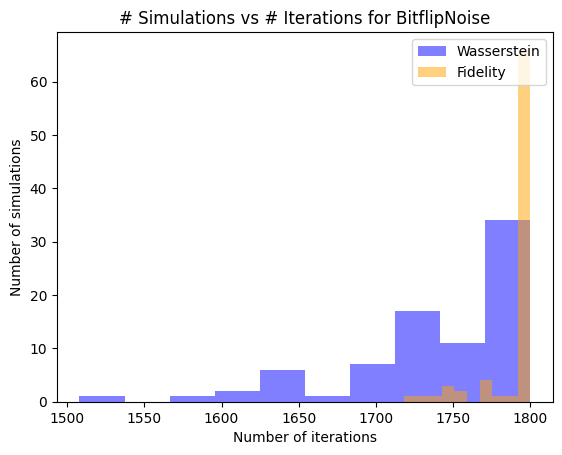

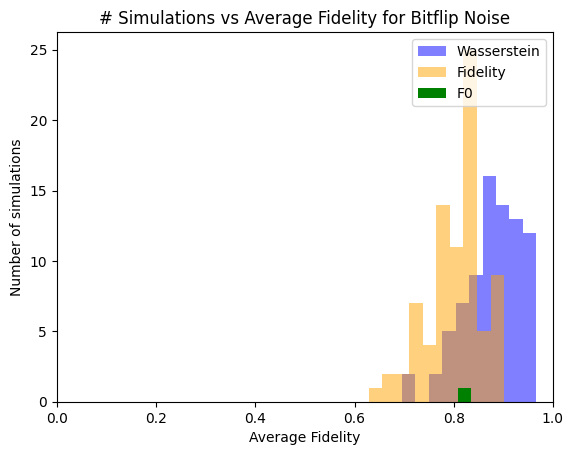

In [22]:
plotSimulation(wassIterationsBitflip, FidelityIterationsBitflip, wassFidelityBitflip, fidelityFidelityBitflip, "Bitflip")

## Phaseflip Results

In [23]:
fidelityIterationsPhaseFlip, fidelityFidelityPhaseFlip = runSimulations(fidelity_cost_phaseflip_noise, False)

In [24]:
wassIterationsPhaseflip, wassFidelityPhaseflip = runSimulations(wasserstein_cost_phaseflip_noise, False)

In [ ]:
print(wassIterationsPhaseflip)
print(wassFidelityPhaseflip)

print(fidelityIterationsPhaseFlip)
print(fidelityFidelityPhaseFlip)

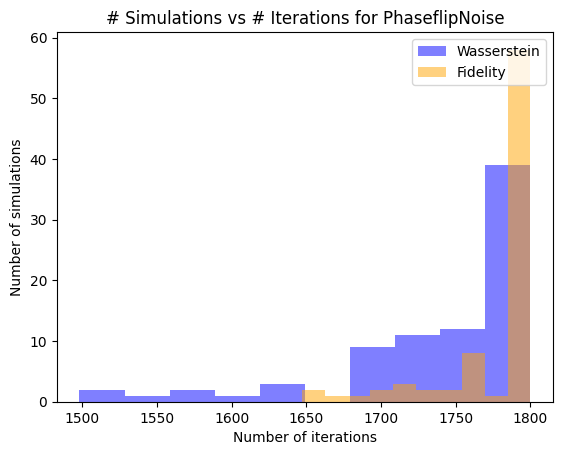

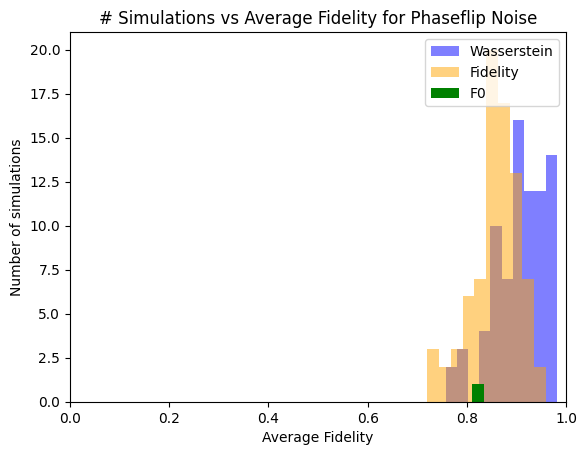

In [26]:
plotSimulation(wassIterationsPhaseflip, fidelityIterationsPhaseFlip, wassFidelityPhaseflip, fidelityFidelityPhaseFlip, "Phaseflip")

## Wasserstein then Fidelity

In [26]:
fidelityDiff = runBothCostSimulations([wasserstein_cost_bitflip_noise, fidelity_cost_bitflip_noise], True)

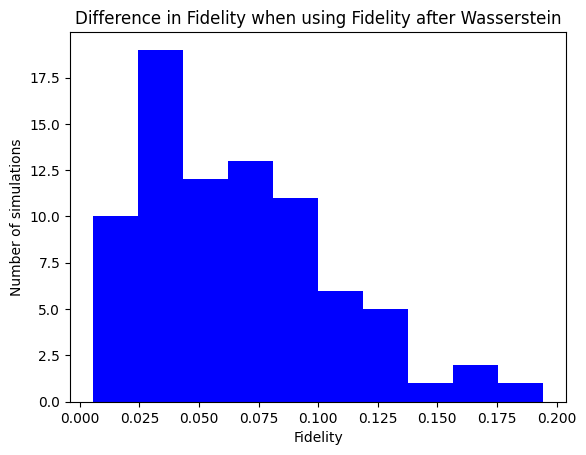

In [27]:
plt.hist(fidelityDiff, color='blue')
plt.xlabel("Fidelity")
plt.ylabel("Number of simulations")
plt.title("Difference in Fidelity when using Fidelity after Wasserstein")
plt.show()

## Fidelity then Wasserstein

In [28]:
fidelityDiff = runBothCostSimulations([fidelity_cost_bitflip_noise, wasserstein_cost_bitflip_noise], True)

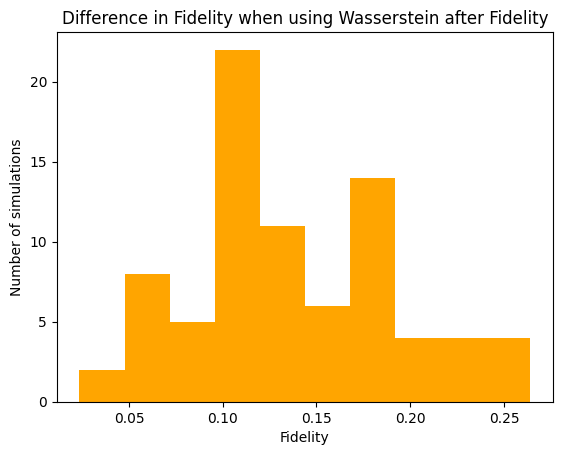

In [29]:
plt.hist(fidelityDiff, color='orange')
plt.xlabel("Fidelity")
plt.ylabel("Number of simulations")
plt.title("Difference in Fidelity when using Wasserstein after Fidelity")
plt.show()

# Reproducing F0

In [33]:
# Number of iterations set as 1 so there is no optimization
num_its = 1

# Number of simulations set as 1 as we only need to see one run
num_sim = 1

In [34]:
def F0_simulation(noiseModel, bitFlip):
    """Runs circuit above without the W_QAB block (ie. noise correction) to reproduce fidelity threshold value, F0

    Args:
        noiseModel (function): The VQA to run
        bitflip (bool): True for bitflip, False for phaseflip
    """
    opt = qml.MomentumOptimizer(stepsize, momentum)

    # Create unitary set of 6 matrices
    I = qml.Identity.compute_matrix()
    X = qml.PauliX.compute_matrix()
    H = qml.Hadamard.compute_matrix()
    S = qml.S.compute_matrix()
    unitaries = [I, X, H, H @ X, S @ H, S @ H @ X]
    
    density_matrices = []
    iterations = []
    for unitary in unitaries:

        # Set alpha and beta as zeros so we don't apply any error correction
        alpha = np.zeros((alpha_length,))
        beta = np.zeros((beta_length,))
        i = 0
        running_costs = []
        while i < num_its:
            (alpha, beta), _cost = opt.step_and_cost(noiseModel(unitary), alpha, beta)
            running_costs.append(_cost)
            i += 1

        density_matrices.append(find_density(unitary, alpha, beta, bitFlip))
        iterations.append(i)

    #Find ideal state for fidelity
    ideal_state = unitary_density()

    #Find state after error correction
    final_state = np.zeros((dim, dim), dtype=complex)
    for i in range(len(density_matrices)):
        final_state += density_matrices[i]
    
    final_state /= len(unitaries)

    fidelity = qml.math.fidelity(ideal_state, final_state)    
    return iterations, fidelity


In [35]:
_, fidelity = F0_simulation(fidelity_cost_phaseflip_noise, False)
fidelity

0.8222222222222216

In [36]:
_, fidelity = F0_simulation(wasserstein_cost_phaseflip_noise, False)
fidelity


0.8222222222222216